# Amazon apparel recommendation system 

In [1]:
#Importing the necessary pacakages
import scipy.sparse
import pickle
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
from matplotlib import gridspec
import seaborn as sns
from collections import Counter
import itertools
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from PIL import Image
from io import BytesIO

# Data Overview

In [2]:
#load json file using pandas
data = pd.read_json('tops_fashion.json')

In [3]:
data.head()

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [4]:
print ("number of data points {}, number of features {}".format(data.shape[0],data.shape[1]))

number of data points 183138, number of features 19


In [5]:
#The number of features of each data point is 19
#name of each feature
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

# Using pertinent features

In [79]:
#as we are going to apply nlp on data['title'] in order to find out similarities between the products
#and the brand and the color of the product
#we remove the irrelavant feature data of the points
data = data[['asin','medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [80]:
#Reduced feature data
data.head()

,asin,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


# Exploratory data analysis

In [81]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [82]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [83]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [84]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [85]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [86]:
a = 28395/183138
print(a*100,'% of the total point have a listed price')

15.504701372735314 % of the total point have a listed price


In [87]:
data.to_pickle('Pickle/180k_apparel_data')
#Saving Data files

In [88]:
data = data[~data['formatted_price'].isnull()]
data.shape

(28395, 5)

In [89]:
#Removing the products with very few titles
#sorting the data alphabetically t
data = data[data['title'].apply(lambda x : len(x.split())>4)]
data.shape[0]

27958

In [90]:
data.to_pickle('Pickle/28k_apparel_data')

We have only relevant 28k out off 183k points. 


# Removing duplicate in titles

Please check commit for previous method used for data['title'] duplicates removal .

Removing duplicates using a better way which removes not just adjacent duplicate titles but same titles throughout the data unlike the previous method used.

Example :
Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt


In [135]:
data = pd.read_pickle('Pickle/28k_apparel_data')

In [136]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

asins1 = []
while len(indices)!=0:
    i = indices.pop()
    asins1.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a list
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in a list
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for h in itertools.zip_longest(a,b): 
            if (h[0]==h[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [141]:
data = data[data['asin'].isin(asins1)]

In [145]:
data.to_pickle('Pickle/16k_apparel_data')

## Text Preprocessing  

In [146]:
data = pd.read_pickle('Pickle/16k_apparel_data')

In [147]:
#data left after 
print("number of data points {}".format(data.shape))

number of data points (16588, 5)


In [148]:
data.head()

,asin,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
27,B014ICEJ1Q,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95
60,B014ICB9A0,https://images-na.ssl-images-amazon.com/images...,APPAREL,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39


In [149]:
# we make a list of stopwords from nltk stopwords lib
stop_words = set(stopwords.words('english'))
print(list(stop_words))

['shan', 'have', 'having', 'am', 'yourself', "that'll", 'some', "it's", 'ma', 'when', 'too', 'out', 'any', 'are', 'in', 'the', "hadn't", 'if', 'both', 'under', 'herself', 'hers', 'an', 'by', 'into', 'who', 'until', 'below', 'me', 'needn', 'mightn', 'can', 'why', "shouldn't", 'had', 'doing', 'there', 'ours', 'because', 'such', 'their', 'i', 'further', "didn't", 'its', 'down', 'no', "aren't", 'we', 'been', "wouldn't", "hasn't", 'my', 'while', 'just', 'for', "you'd", 'ain', 'over', 'themselves', 'those', 'between', 'will', "you'll", 'yours', 'did', 'same', 'weren', 'd', "mightn't", "weren't", 'but', 'few', "haven't", 'a', 'after', 'than', 'through', 'o', 've', 'his', 'himself', 'here', 'our', 'you', 'up', 'mustn', 'doesn', 'all', 'couldn', "don't", 'off', 'should', "shan't", 'each', 'do', 'be', 'ourselves', 'about', 'other', 'to', 'him', 're', 'once', 'don', "isn't", 'nor', 'these', 'haven', 'what', 'again', "needn't", 'shouldn', "won't", 'on', 'of', 'at', 'before', 'hasn', 'more', 'isn',

In [150]:
def preprocessing(text,index,column):
    if type(text) is not int:
        string = ""
        for word in text.split():
            #removing special characters
            words = ("".join(i for i in word if i.isalnum()))
            #making all the words as lower case
            words = words.lower()
            #removal of stop words
            if words not in stop_words:
                string += words + " "
        data[column][index] = string     

In [151]:
for index,rows in data.iterrows():
    preprocessing(rows['title'],index,'title')

In [152]:
# Tried using stemmin on our titles, did not work well for our titles

In [153]:
data.to_pickle('Pickle/16k_nlp_processed_apparel_data')

In [2]:
data = pd.read_pickle('Pickle/16k_nlp_processed_apparel_data')

In [ ]:
#downloading all the images
from PIL import Image
import requests
from io import BytesIO

for index, row in data.iterrows():
        try:
            url = row['medium_image_url']
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.save('16k_images/'+row['asin']+'.jpeg')
        except:
            pass

# Text based product similarity

## Utility Function

In [3]:
# Building utility functions to be used throughout the workshop

#display an image
def display_img(url):
    #we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
#plotting to see the algorithms decision
def plot_heatmap(keys,values,labels,url,text):
    #keys gives us the list of words for recommended title
    
    #we will divide the figure into two parts
    gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
    fg = plt.figure(figsize=(25,3))
    
    #1st figure plotting a heatmap that represents the most commonly occuring words
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]),annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)
    
    #plotting the 2nd figure as image
    
    fg = plt.subplot(gs[1])
    fg.set_xticks([])
    fg.set_yticks([])
    fig = display_img(url)
    
    #display combine figure
    plt.show()

def plot_heat_map_image(doc_id,vec1,vec2,url,text,model):
    
    #doc_id : index of title1
    #vec1 : input apparels vector
    #vec2 : recommended apparels vector,
    #url : image url
    #text : title of the recommended title
    #model it can be any of the three models:
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
        
        
        intersection =  set(vec1.keys()) & set(vec2.keys())
        
        # we set the value of non intersecting word to zero in vec2
        for i in vec2.keys():
            if i not in intersection:
                vec2[i]=0
        # if ith word in intersection(list of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0
            values = [vec2[x] for x in vec2.keys()]
        # for labeling heat map
            keys = list(vec2.keys())
            
        if model == 'bag_of_words':
            labels = values
        elif model == 'tf_idf':
            labels = []
            for x in vec2.keys():
                #tfidf_title_vectorizer.vocabulary contains all the words in the corpus
                if x in tfidf_title_vectorizer.vocabulary_:
                    labels.append(tfidf_title_features[doc_id,tfidf_title_vectorizer.vocabulary_[x]])
                #for words not present int the corpus
                else:
                    labels.append(0)
                    
                
        elif model == 'idf':
            labels =[]
            for x in vec2.keys():
                #idf_title_vectorizer.vocabulary contains all the words in the corpus
                if x in idf_title_vectorizer.vocabulary_:
                    labels.append(idf_title_features[doc_id,idf_title_vectorizer.vocabulary_[x]])
                #for words not present int the corpus
                else:   
                    labels.append(0)
        plot_heatmap(keys,values,labels,url,text)
        
        
                    
def text_to_vector_conversion(text):
    words = text.split()
    return Counter(words)

def results(doc_id,text1,text2,url,model):
    
    vector1 = text_to_vector_conversion(text1)
    vector2 = text_to_vector_conversion(text2)
    
    plot_heat_map_image(doc_id,vector1,vector2,url,text2,model)    

## Bag of words based product similarity

In [4]:
title_vectorizer = CountVectorizer()
title_feature = title_vectorizer.fit_transform(data['title'])
# CountVectorizer().fit_transform(data['title']) returns a sparse matrix with dimensions  =  no. points * words_in_corpus

title_feature.shape

(16588, 12745)

In [5]:
def bag_of_words_model(doc_id,cut_off):
    #doc_id is the number on the new index formed after CountVectorizer is applied to the data['title']
    #pairwise distance will save the distance between given input apparel and all other apparels
    pairwise_dist = pairwise_distances(title_feature,title_feature[doc_id])
    
    #np.argsort will return indices of the smallest distances
    indice = np.argsort(pairwise_dist.flatten())[0:cut_off]
    
    #get the index of the original dataframe
    data_indices = list(data.index[indice])
    
    for i in range(0,len(data_indices)):
        results(indice[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], 'bag_of_words')
        print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))

#try 12470
#try 12434

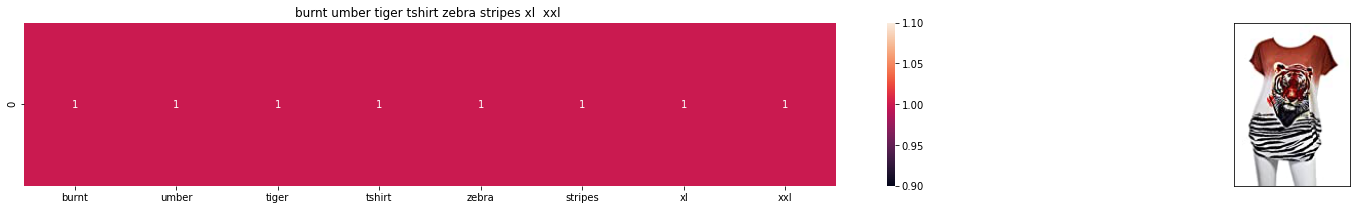

The amazon ID of the apparel is B00JXQB5FQ


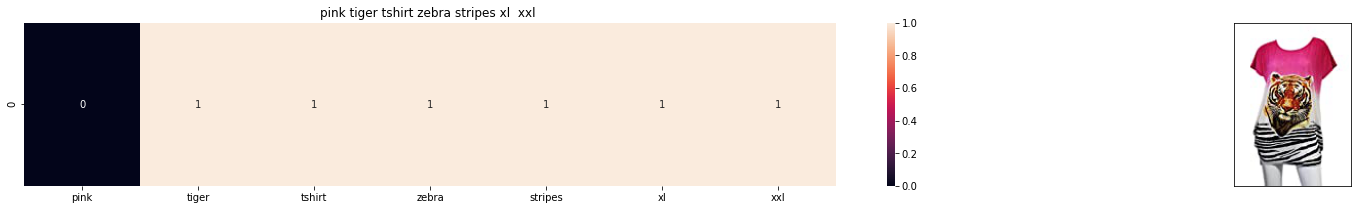

The amazon ID of the apparel is B00JXQASS6


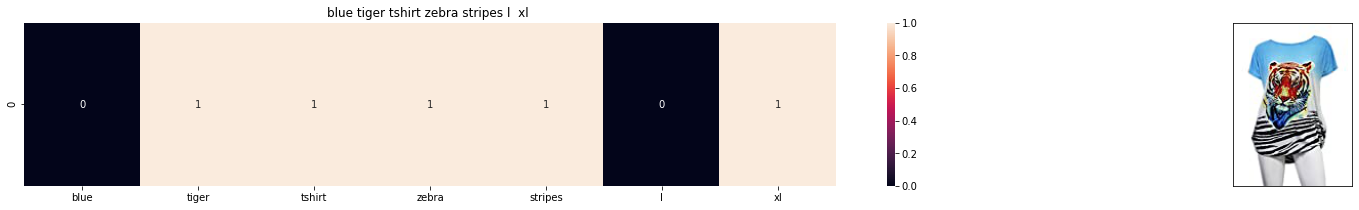

The amazon ID of the apparel is B00JXQANA4


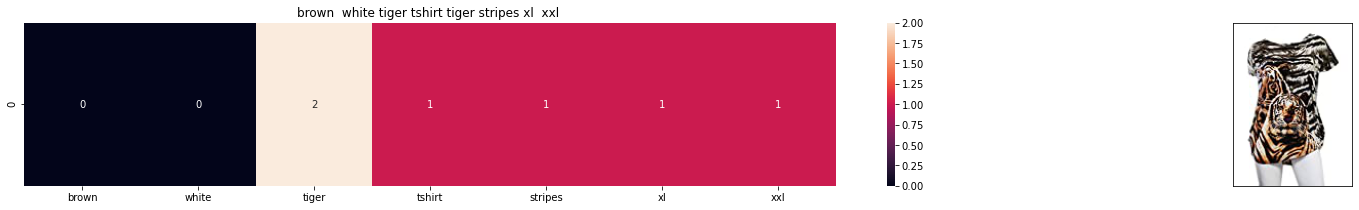

The amazon ID of the apparel is B00JXQCWTO


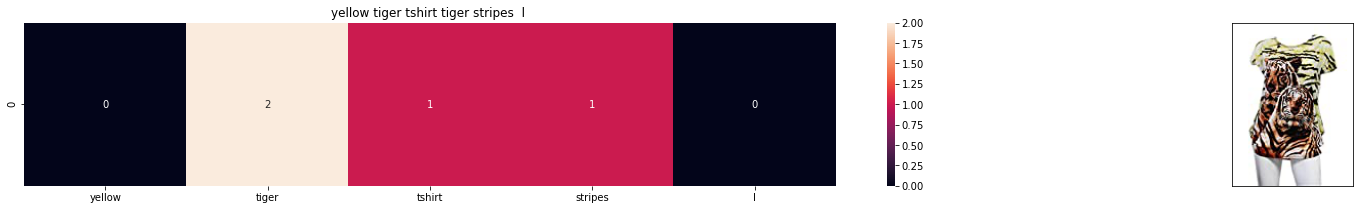

The amazon ID of the apparel is B00JXQCUIC


In [6]:
bag_of_words_model(12434,5)

## Tfifdf based product similarity

In [7]:
tfidf_title_vectorizer = TfidfVectorizer()
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tfidf_title_features.shape

(16588, 12745)

In [8]:
#finding similarit between two vectors using 
def tfidf_model(doc_id,cut_off):
    #gives us the eucledian distance between our vector representing data point[i]/ title[i] and all other title vector representation
    
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances  
    indices = np.argsort(pairwise_dist.flatten())[:cut_off]
    
    #data indices in our original data set
    data_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        results(indices[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]],'tf_idf')
        print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))

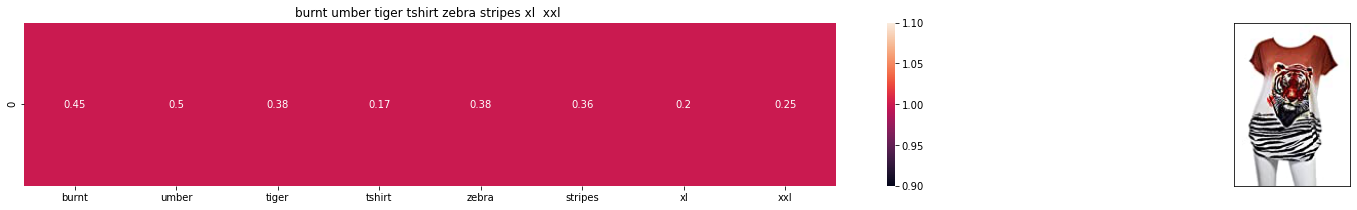

The amazon ID of the apparel is B00JXQB5FQ


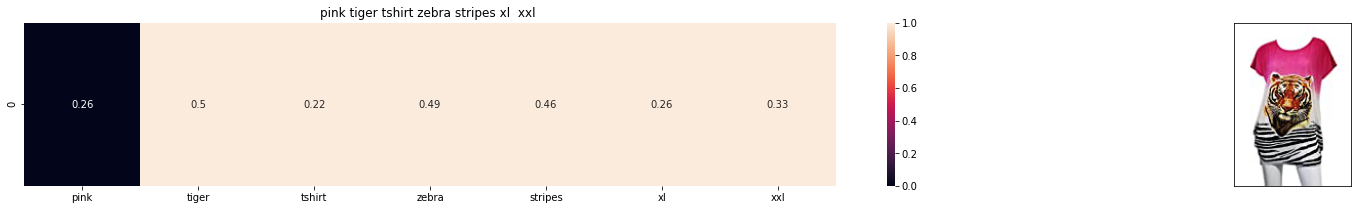

The amazon ID of the apparel is B00JXQASS6


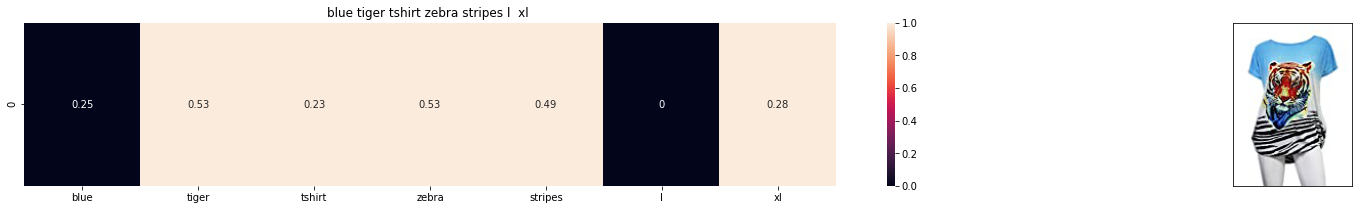

The amazon ID of the apparel is B00JXQANA4


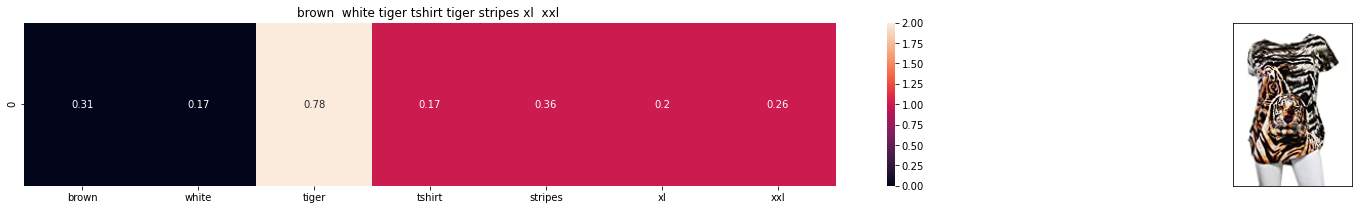

The amazon ID of the apparel is B00JXQCWTO


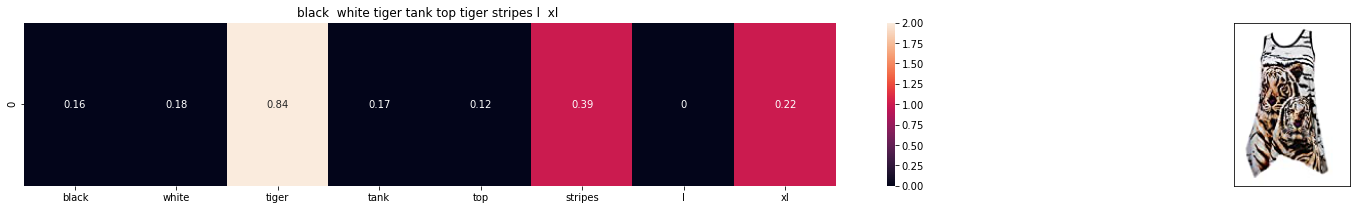

The amazon ID of the apparel is B00JXQAM0A


In [9]:
tfidf_model(12434,5)
#12434

# IDF Based product similarity

In [42]:

def containing(word):
    #returns the number of documents which have the word
    return sum(1 for sentence in data['title'] if word in sentence.split())
def idf(word):
    return math.log(data.shape[0] / (containing(word)))
    

In [43]:

idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #no of_data_points * #words_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features gives the number of times the word occured in that doc


In [44]:

#converting all the values into float
idf_title_features = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    #we find idf values for all the given words in the corpus
    idf_value = idf(i)
    
    for j in idf_title_features[:,idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_value
        

In [46]:

def idf_model(doc_id,cut_off):
    #gives us the eucledian distance between our vector representing data point[i]/ title[i] and all other title vector representation
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances sorted 
    indices = np.argsort(pairwise_dist.flatten())[:cut_off]
    
    #converts the indicices into a list of original dataset indices using data.index
    data_indices = list(data.index[indices])
    
    for i in range(0,len(data_indices)):
        results(indices[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]],'idf')
        print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))

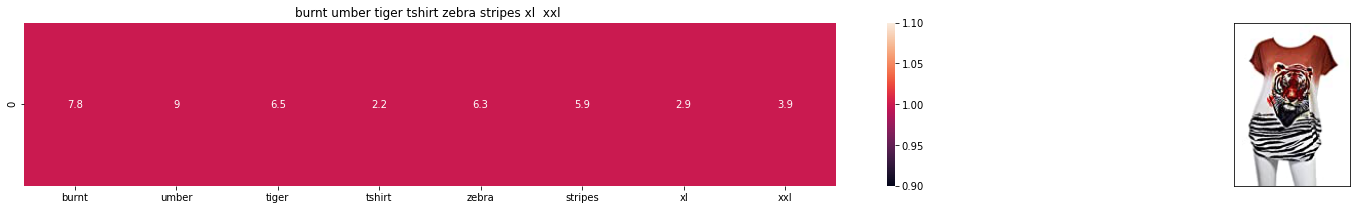

The amazon ID of the apparel is B00JXQB5FQ


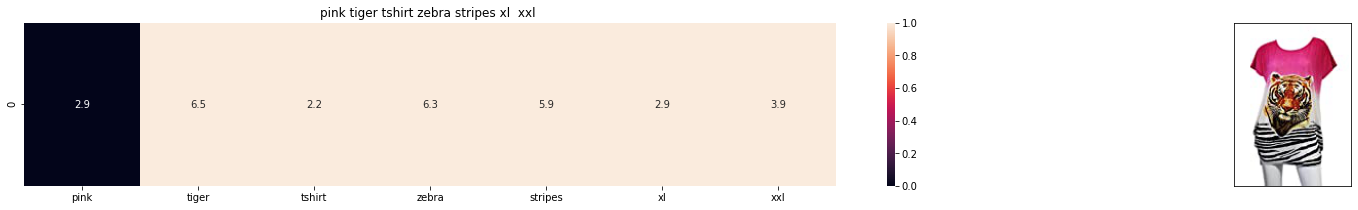

The amazon ID of the apparel is B00JXQASS6


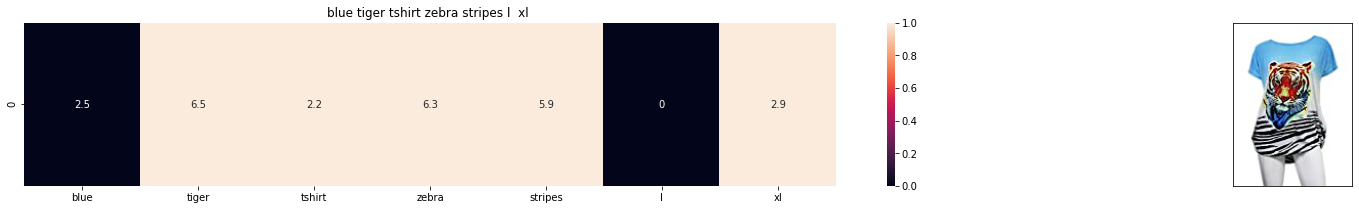

The amazon ID of the apparel is B00JXQANA4


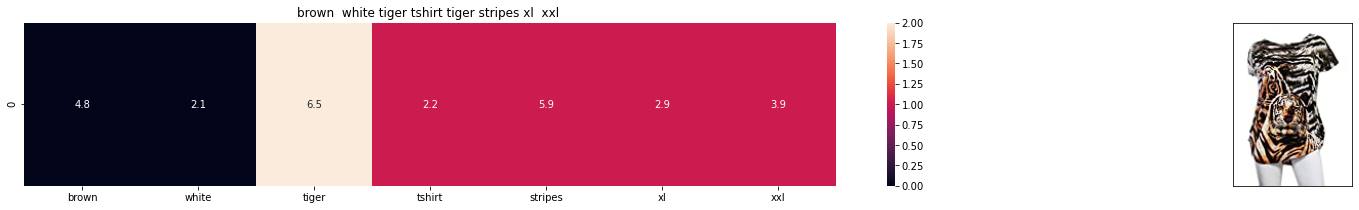

The amazon ID of the apparel is B00JXQCWTO


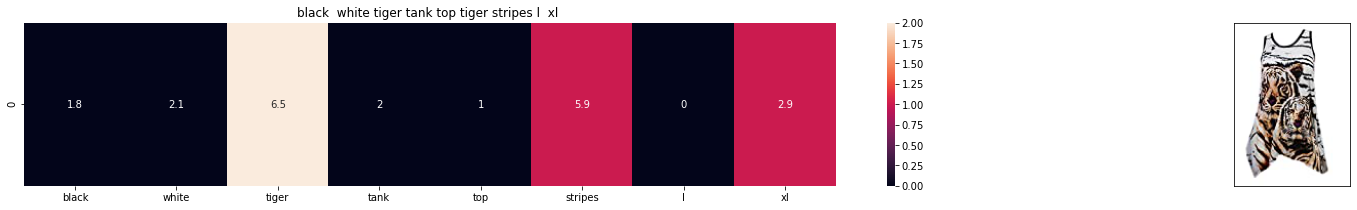

The amazon ID of the apparel is B00JXQAM0A


In [48]:
idf_model(12434,5)

In [33]:
idf_title_features.shape

(16588, 12745)

# Semantic meaning based apparel similarity

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# download "GoogleNews-vectors-negative300.bin" 

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
'''
#create a dictionary contaning vector representaion from google word2vec of our word corpus

vocab = model.index_to_key
#gives us a list of all the words in google word2vec library

vocab1 = tfidf_title_vectorizer.vocabulary_.keys()
#gives us a list of all the words in our corpus

models = {} 
#empty dictionary

for i in vocab1:
    if i in vocab:
        models.update(i:model[i])
        

#models will contain google's vector representation for our word corpus
'''

In [11]:
#uitlity function to better visualize and understand results

def get_word_vec(sentence,doc_id,model_name):
    #doc_id in our corpus
    #sentence : title of apparel
    #model_name : 'avg', we will append the model[i], w2v representation of word i
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if model_name == 'avg':
                vec.append(model[i])
            if model_name == 'weighted':
                vec.append(tfidf_title_features[doc_id,tfidf_title_vectorizer.vocabulary_[i]] * model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return np.array(vec)
def get_distance(vec1,vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
            
    return np.array(final_dist)
def heat_map(sentence1,sentence2,url,doc_id1,doc_id2,model_name):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # model:  'avg'

    sentence_vec1 = get_word_vec(sentence1,doc_id1,model_name)
    sentence_vec2 = get_word_vec(sentence2,doc_id2,model_name)
    
    #sent1_sent2_dist = eucledian distance between i and j
    #sent1_sent2_dist = np array with dimensions(#number of words in title1 * #number of words in title2)
    sent1_sent2_dist = get_distance(sentence_vec1,sentence_vec2)
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    
    gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
    fg = plt.figure(figsize=(35,25))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(sent1_sent2_dist,4), annot = True)
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    #setting the fontsize and rotation of x tick tables
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12,rotation=90)
    ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 12,rotation=45)
    
    fg = plt.subplot(gs[1])
    fg.set_xticks([])
    fg.set_yticks([])
    fig = display_img(url)
    
    #display combine figure
    plt.show()    

## Avg Word2Vec based movie recommendation model

In [12]:
# this function will add the vectors of each word and returns the avg vector of given sentance

vocab = model.index_to_key
# vocab = stores all the words in google Word2vec model

def avg_word_vec(sentences,no_features,doc_id,model_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # model_name: model information it will take two values
        # if  model_name == 'avg', we will add the value model[i], w2v representation of word i
        # if mode_name ='weighted' we will add the value idf_title_features[doc_id,idf_title_vectorizer[word]] * model[word]
    
    
    featureVec = np.zeros(shape=(300,),dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    
    ncount = 0
    for word in sentences.split():
        ncount += 1
        if word in vocab:
            if model_name == 'avg':
                featureVec = np.add(featureVec,model[word])
            elif mode_name == 'weighted' and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec,idf_title_features[doc_id,idf_title_vectorizer[word]] * model[word])
        
    if (ncount>0):
        featureVec = np.divide(featureVec,ncount)
    # returns an avg vector    
    return featureVec

In [13]:
doc_id = 0
w2vec_title_features = []
#for every title we build a vector
for i in data['title']:
    w2vec_title_features.append(avg_word_vec(i,300,doc_id,'avg'))
    doc_id += 1

#w2v_title = np.array(# number of doc/rows in courpus * 300) 
w2vec_title_features = np.array(w2vec_title_features)    

In [14]:
def word2vec(doc_id,cut_off):
    #doc_id is the number on the new index formed after TfidfVectorizer is applied to the data['text']
    #pairwise distance will save the distance between given input apparel[doc_id] and all other apparels
    pairwise_dist = pairwise_distances(w2vec_title_features,w2vec_title_features[doc_id].reshape(1,-1))
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances
    indices = np.argsort(pairwise_dist.flatten())[:cut_off]
    
    #data indices in our original data set
    data_indices = list(data.index[indices])
    
    for i in range(0,len(data_indices)): 
        print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))
        print('{} '.format(data['title'].loc[data_indices[i]]))
        heat_map(data['title'].loc[data_indices[0]],data['title'].loc[data_indices[i]],data['medium_image_url'].loc[data_indices[i]],indices[0],indices[i],'avg')
        
        print(' ')

The amazon ID of the apparel is B00JXQB5FQ
burnt umber tiger tshirt zebra stripes xl  xxl  


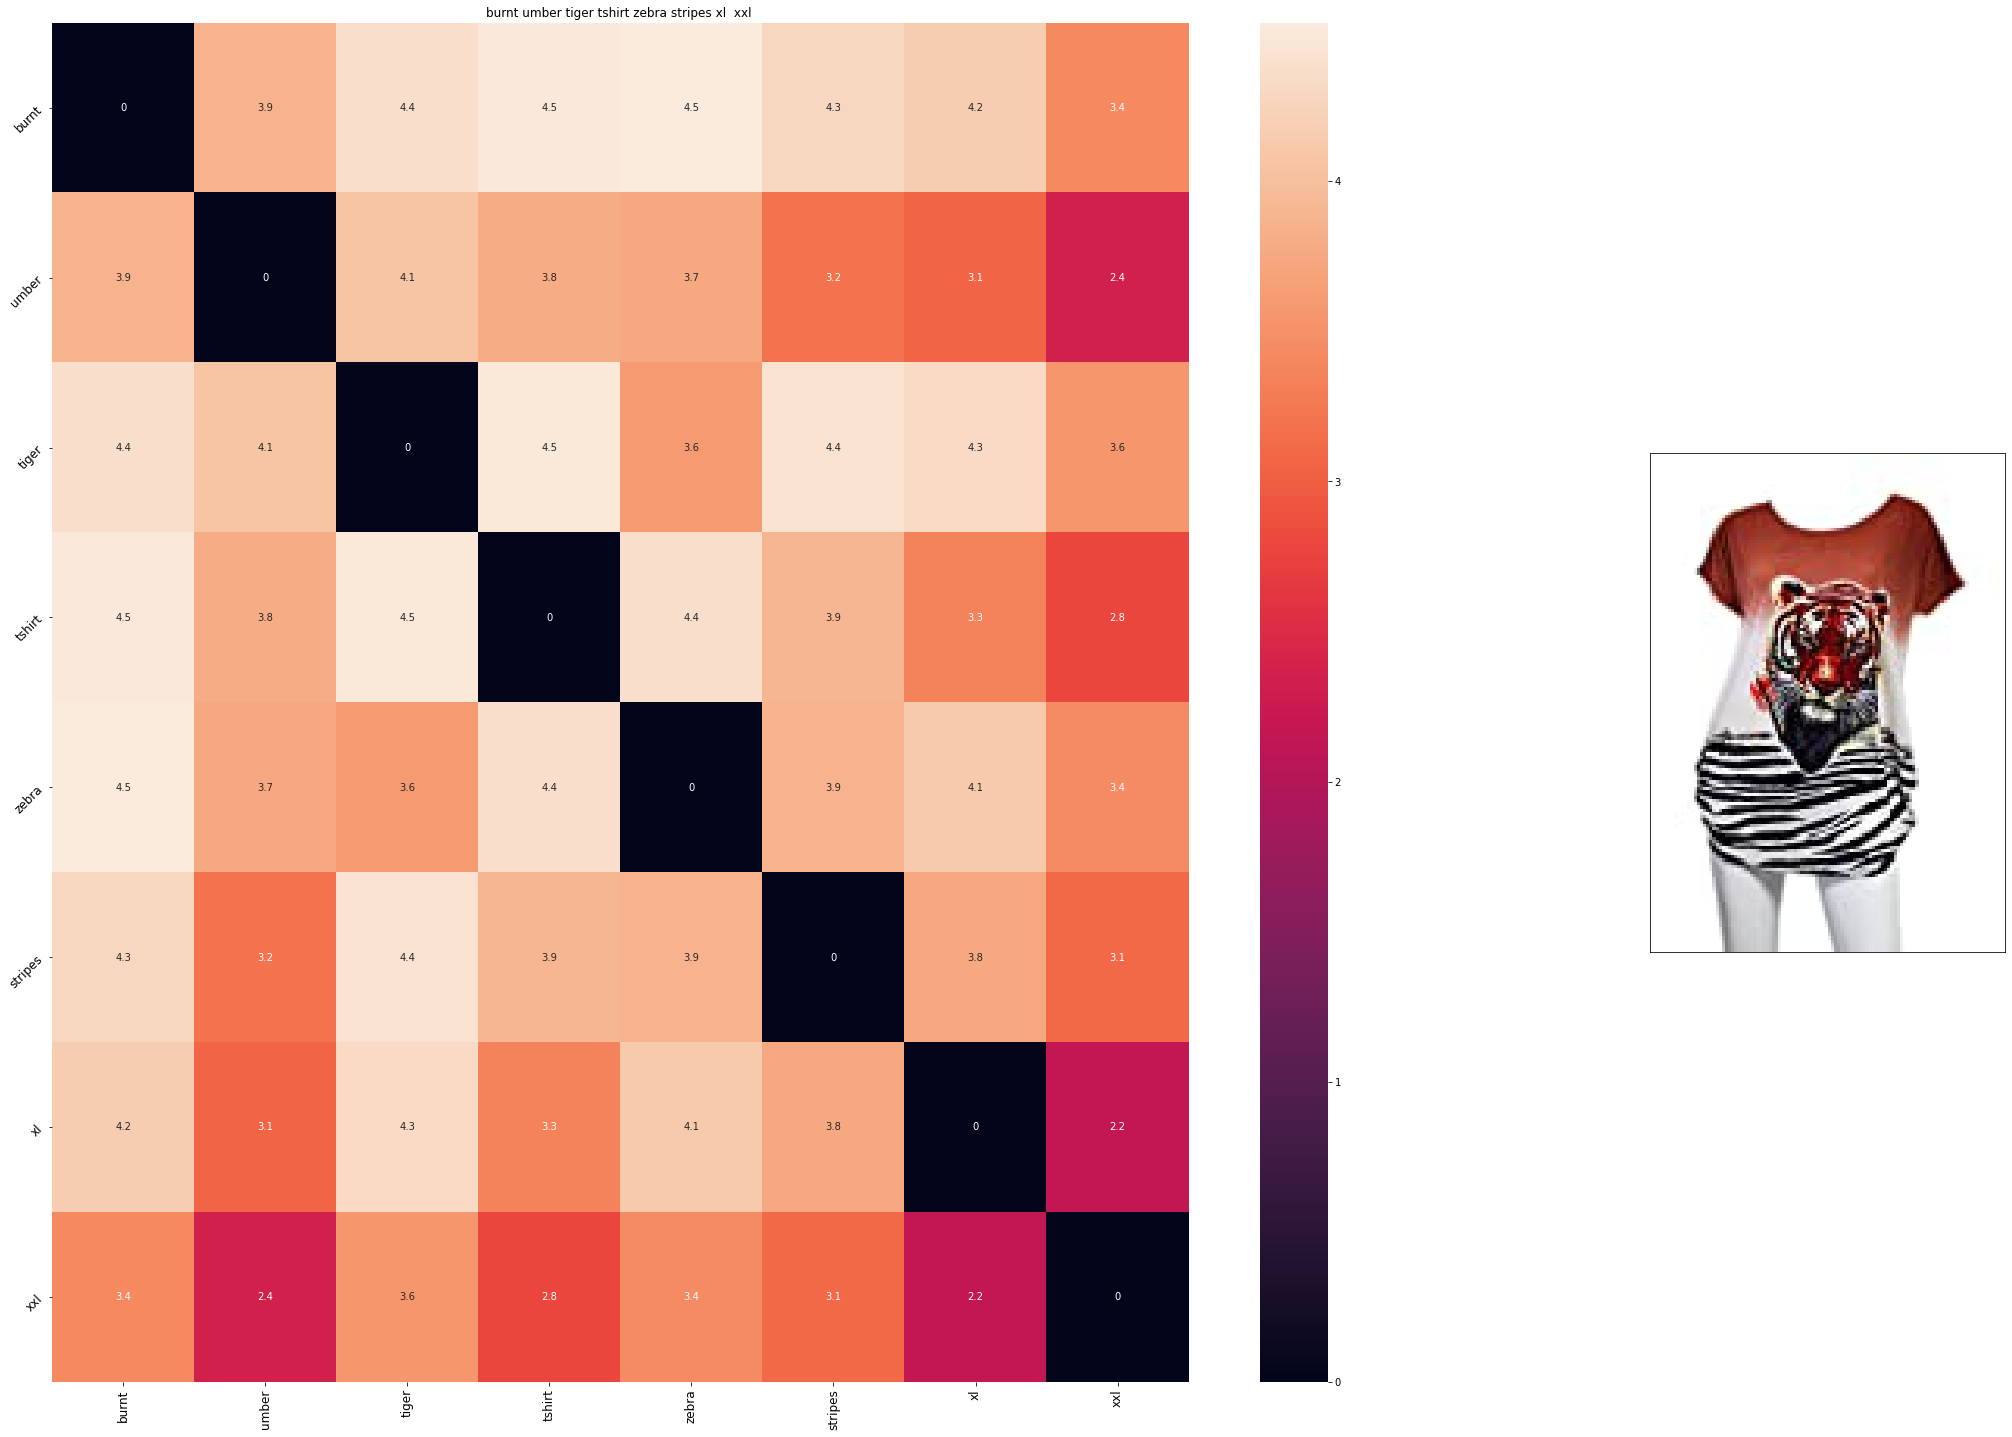

 
The amazon ID of the apparel is B00JXQASS6
pink tiger tshirt zebra stripes xl  xxl  


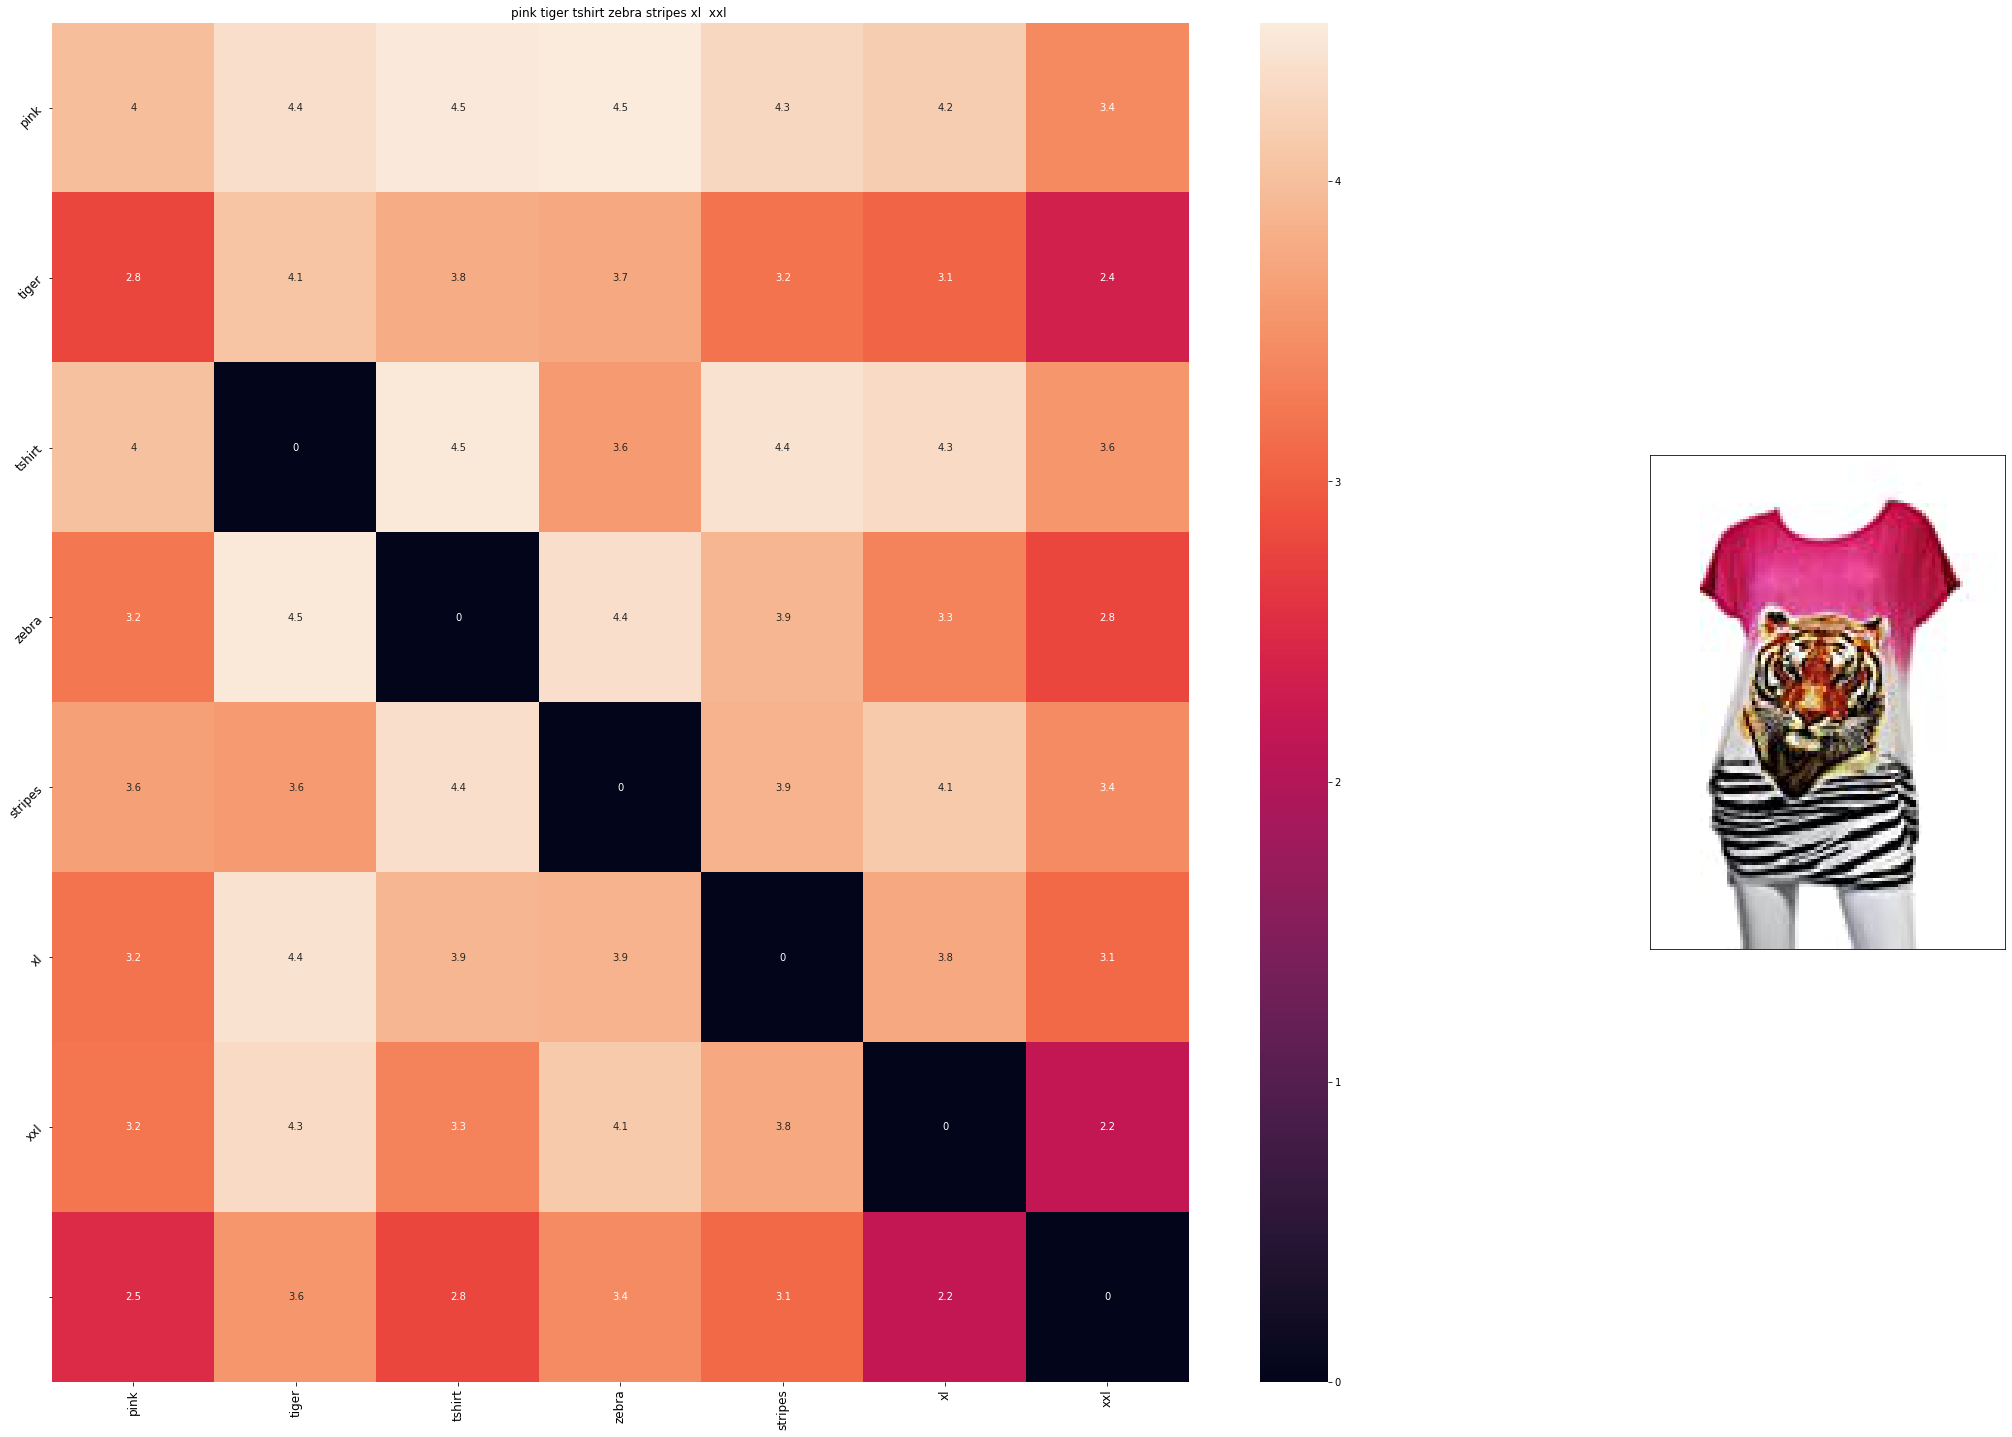

 
The amazon ID of the apparel is B00JXQANA4
blue tiger tshirt zebra stripes l  xl  


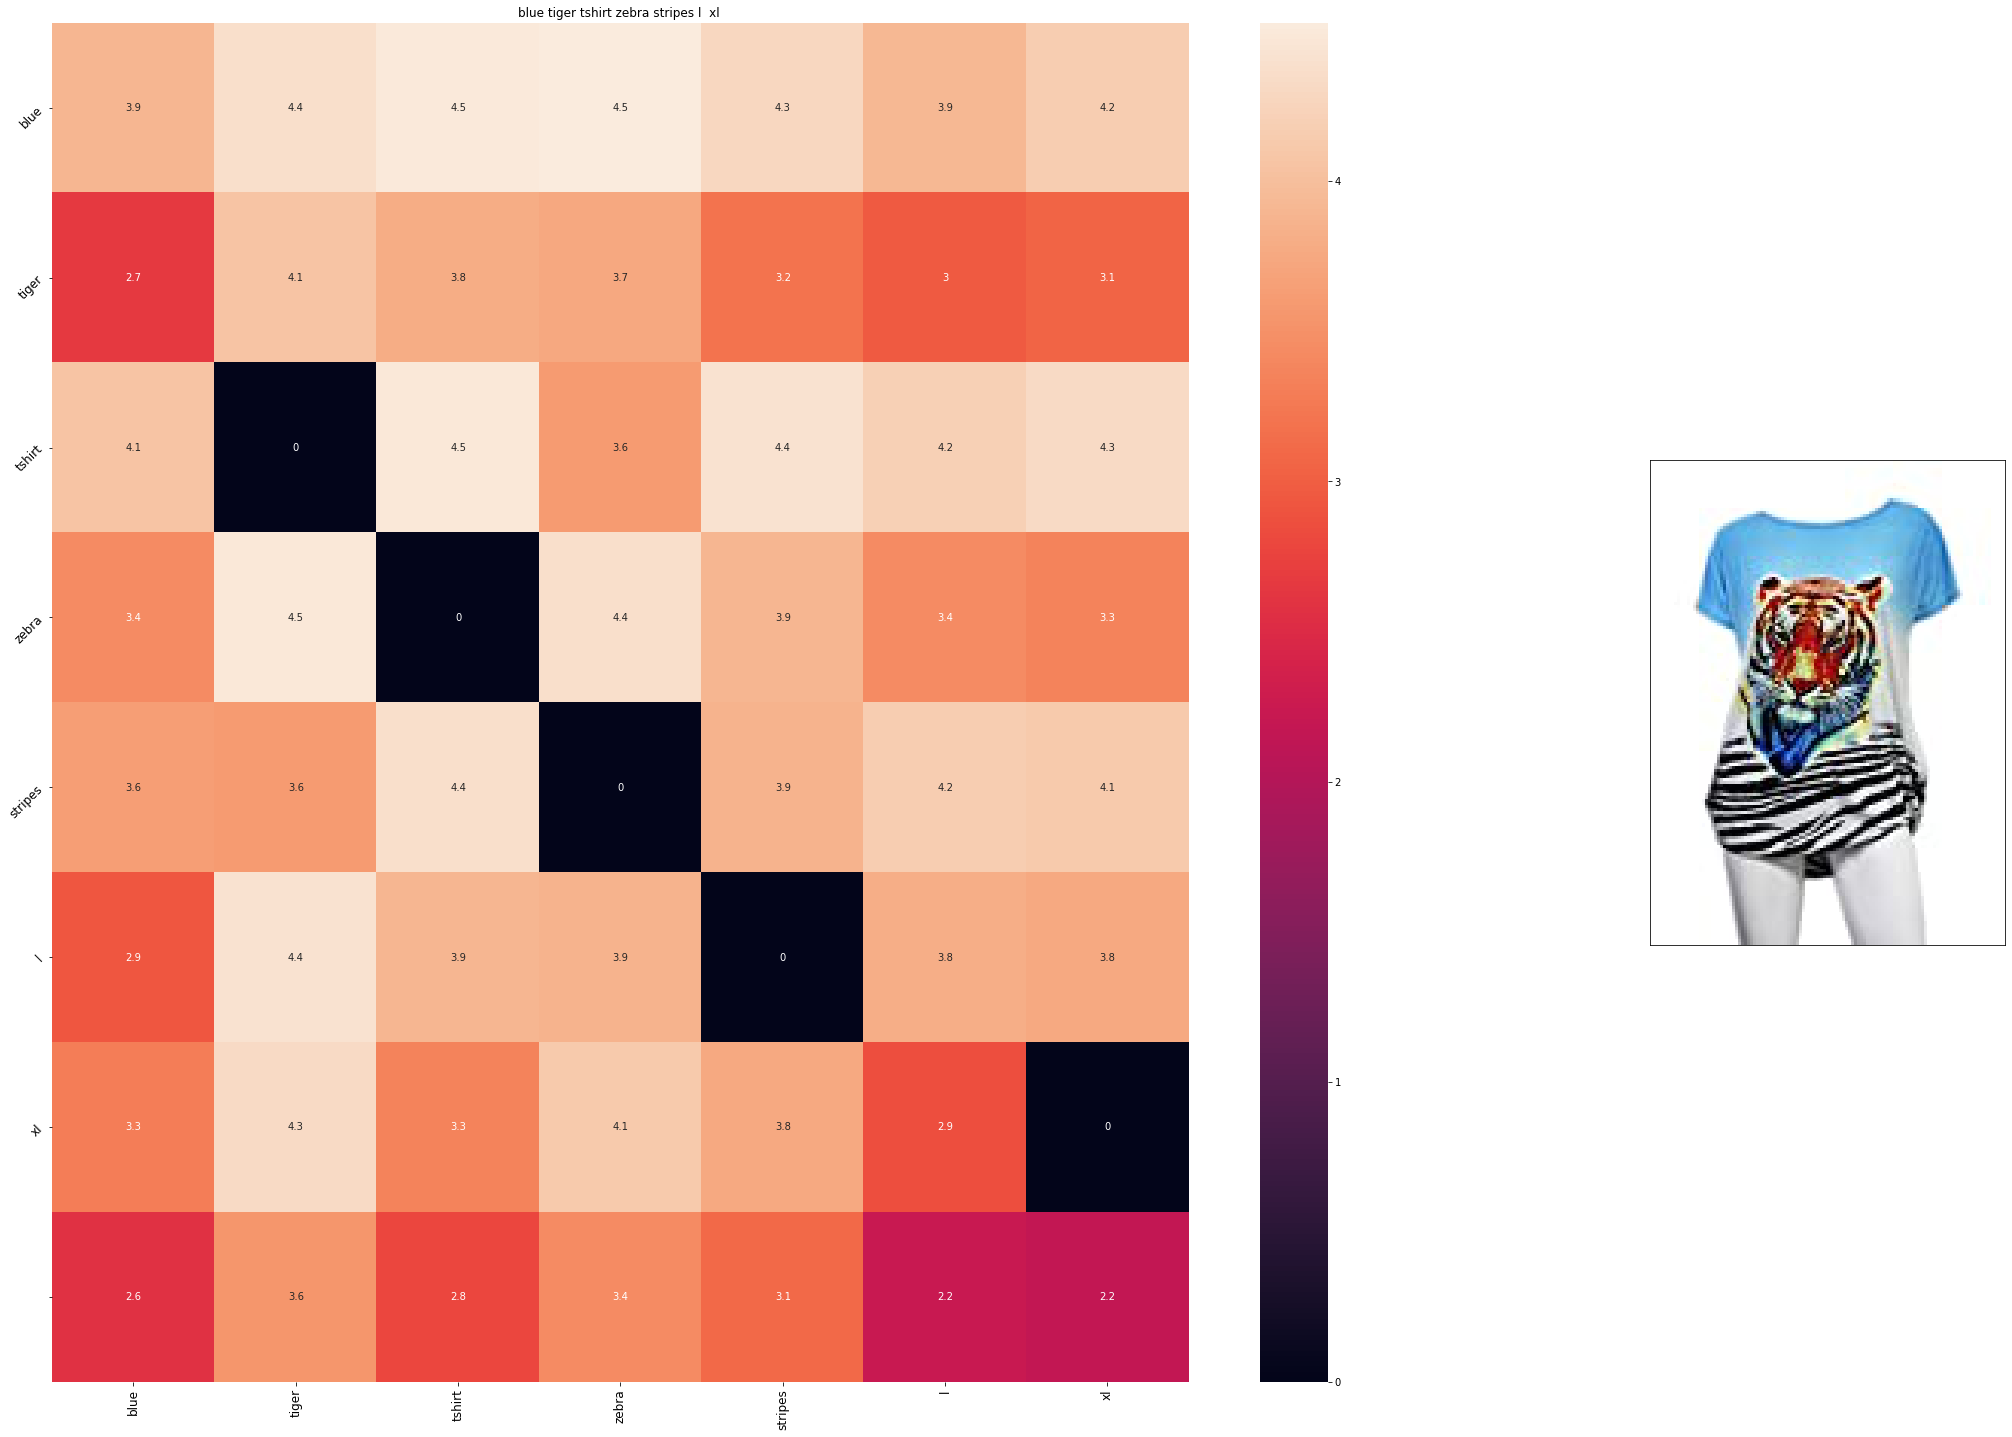

 
The amazon ID of the apparel is B00JXQCWTO
brown  white tiger tshirt tiger stripes xl  xxl  


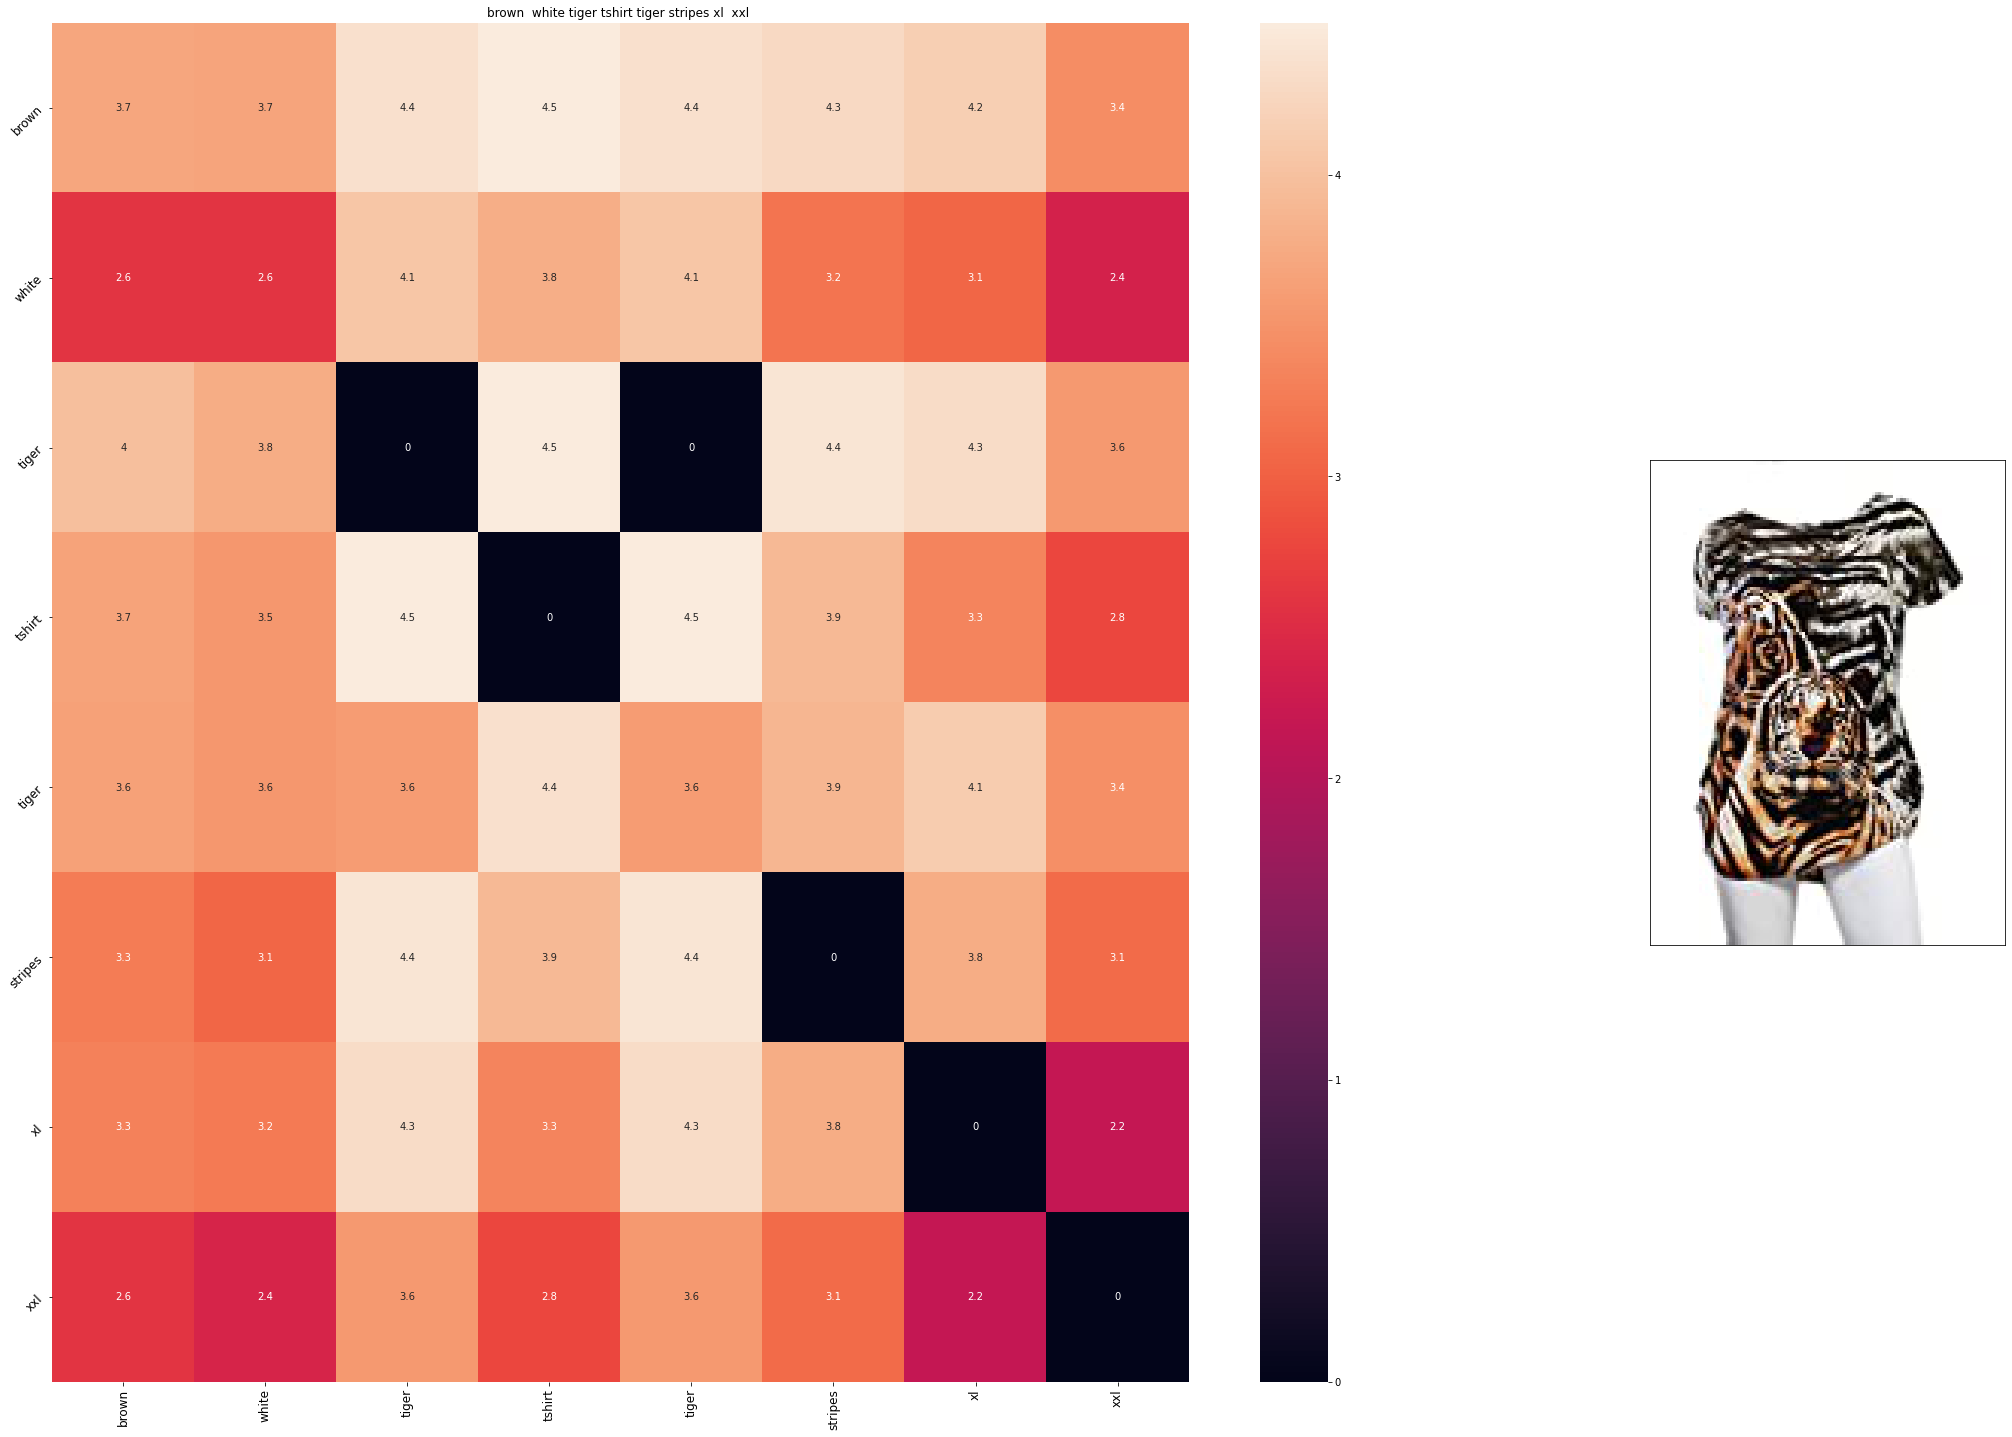

 
The amazon ID of the apparel is B00JXQAA9I
grey  white tiger tshirt tiger stripes  l  


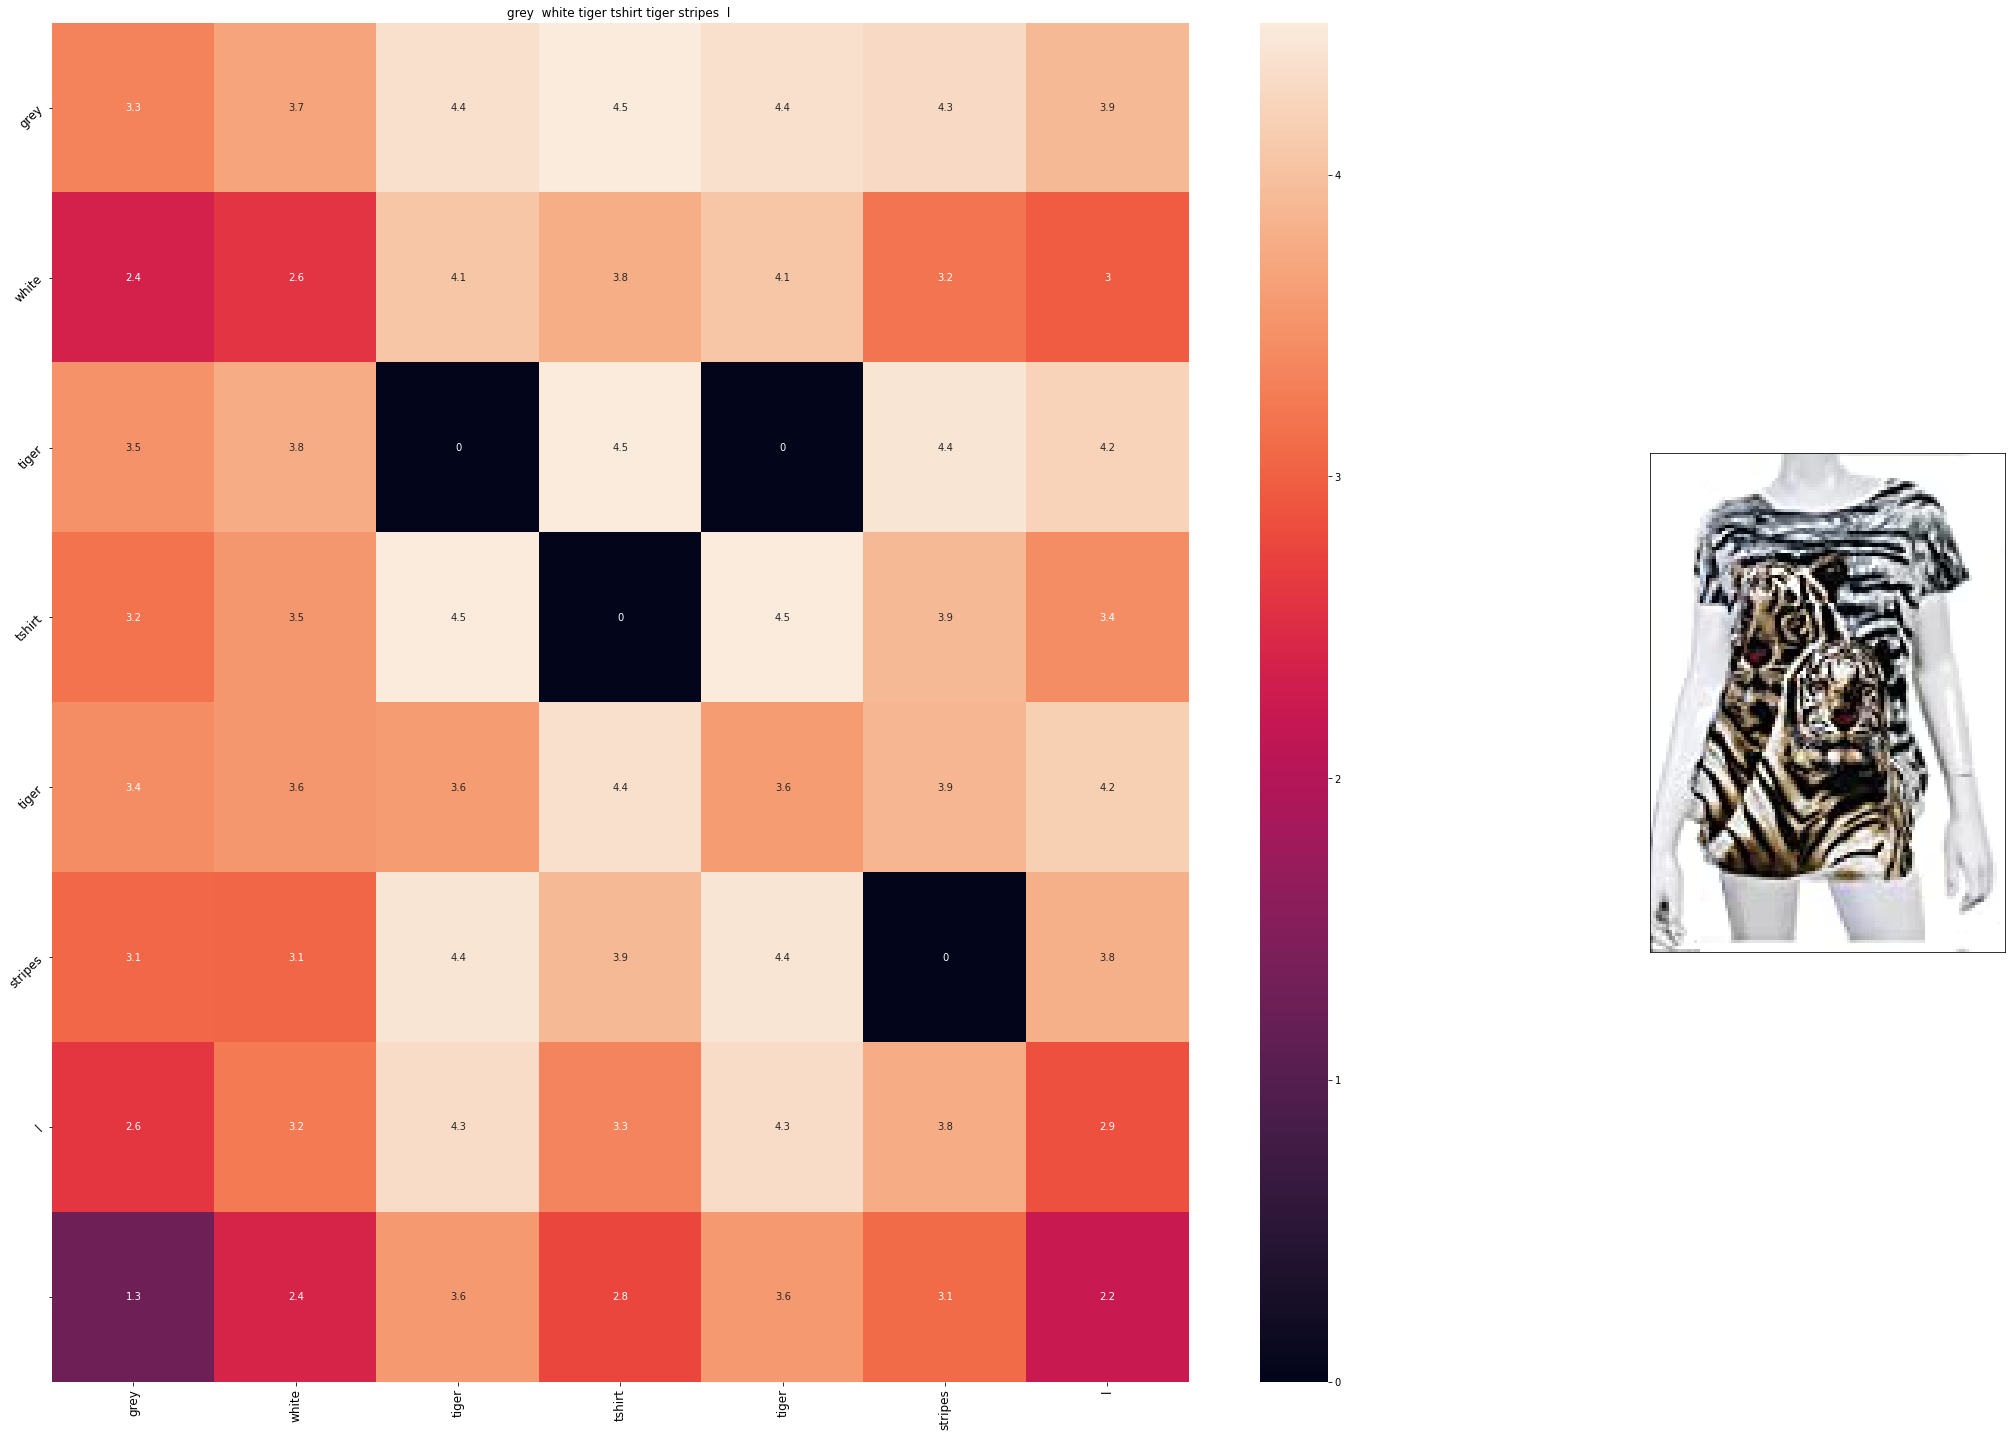

In [15]:
word2vec(12434,5)